In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
# print(mpl.rcParams.items)
mpl.use('Agg')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
# mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline
# print(mpl.rcParams.items)

<!-- ![](./header.png) -->
<img src="./header.png",width=100%>

# The Photometric LSST Astronomical Time-series Classification Challenge (PLAsTiCC): Selection of a performance metric

*Alex Malz (NYU)*, 
*Renee Hlozek (U. Toronto)*, 
*Tarek Alam (UCL)*, 
*Anita Bahmanyar (U. Toronto)*, 
*Rahul Biswas (U. Stockholm)*, 
*Emille Ishida (Clermont)*, 
*David Jones (Berkeley)*, 
*Ashish Mahabal (CfA)*, 
*Rafael Martinez-Galarza (Harvard)*, 
*Gautham Narayan (STScI)*

We describe and illustrate the process by which a global performance metric was chosen for Photometric LSST Astronomical Time-series Classification Challenge (PLAsTiCC), a Kaggle competition aiming to identify promising transient and variable classifiers for LSST by involving the broader community outside astronomy.

Introduction
============

The metric of this note is for the first version of the Kaggle competition, though there are future plans for an early classification challenge and identification of class-specific metrics for different science goals.  

* The metric must return a single scalar value.
* The metric must be well-defined for non-binary classes.
* The metric must balance diverse science use cases in the presence of heavily nonuniform class prevalence.
* The metric must respect the information content of probabilistic classifications.
* The metric must be able to evaluate deterministic classifications.
* The metric must be interpretable, meaning it gives a more optimal value for "good" mock classifiers and a less optimal value for mock classifiers plagued by anticipated systematic errors; in other words, it must pass basic tests of intuition.
* The metric must be reliable, giving consistent results for different instantiations of the same test case.

The Probabilistic Classification Metric (ProClaM) code used in this exploration of performance metrics is publicly available on [GitHub](https://github.com/aimalz/proclam).

In [3]:
import proclam
from proclam import *

Data
====

We confirm the behavior of the metrics on mock data with well-understood systematics as well as real data from past classification challenges.

## Mock classifier systematics

* guessing: random classifications across all classes
* uncertain: uniform probabilities across all classes
* perfect: perfectly accurate on all classes
* almost: a slight perturbation of the perfect classifier
* noisy: a large perturbation of the perfect classifier
* tunnel vision: classifies one class well and others randomly
* cruise control: classifies all objects as a single class
* subsumed: consistently misclassifies one class as one other class

In [4]:
plasticc = {}
plasticc['label'] = 'ProClaM'
plasticc['names'] = []
plasticc['cm'] = {}
plasticc['delta'] = {}

In [5]:
M_classes = 13

In [6]:
chosen = np.random.randint(0, M_classes)
print(chosen)

11


In [7]:
def plot_cm_from_cm(cm, text):
    plt.matshow(cm, vmin=0., vmax=1.)
    plt.title(text)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.show()
    plt.close()
    
def wrap_up_classifier(cm, testname, info_dict, delta=0.1):
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    plot_cm_from_cm(cm, testname)
    info_dict['names'].append(testname)
    info_dict['cm'][testname] = cm
    info_dict['delta'][testname] = delta
    return info_dict

### Guessing classifier

Totally random CM

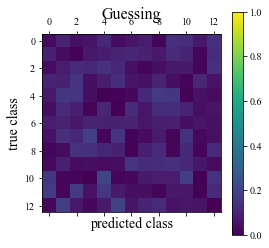

In [8]:
cm = np.random.uniform(size=(M_classes, M_classes))
plasticc = wrap_up_classifier(cm, 'Guessing', plasticc, delta=0.01)

### Uncertain

Totally uniform CM

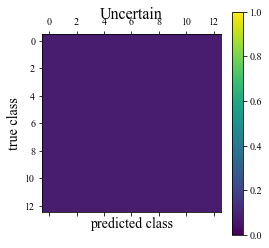

In [9]:
cm = np.ones((M_classes, M_classes))
plasticc = wrap_up_classifier(cm, 'Uncertain', plasticc, delta=0.01)

### Perfect classifier

Identity matrix CM

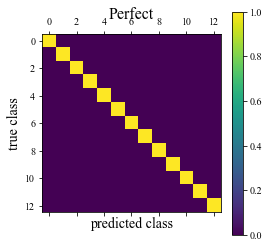

In [10]:
cm = np.eye(M_classes)
plasticc = wrap_up_classifier(cm, 'Perfect', plasticc, delta=0.)

### Almost perfect classifier

Identity matrix CM plus low-amplitude uniform

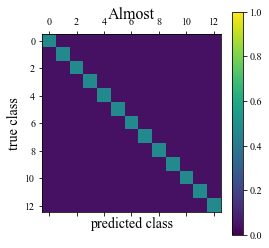

In [11]:
cm = np.eye(M_classes) + 0.1 * np.ones((M_classes, M_classes))
plasticc = wrap_up_classifier(cm, 'Almost', plasticc, delta=0.01)

### Noisy classifier

Identity matrix CM plus high-amplitude uniform

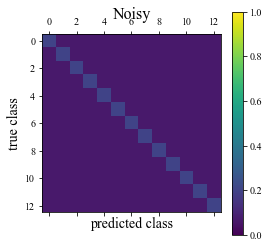

In [12]:
cm = np.eye(M_classes) + 0.5 * np.ones((M_classes, M_classes))
plasticc = wrap_up_classifier(cm, 'Noisy', plasticc)

### Tunnel vision classifier

accurate predictions on one class and uniform on others

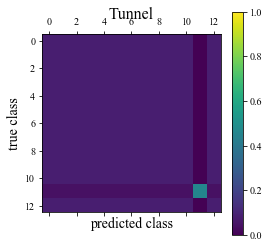

In [13]:
cm = np.ones((M_classes, M_classes))
cm = cm * 0.1
cm[:, chosen] = np.zeros((M_classes))[np.newaxis, :]
cm[chosen][chosen] = 1.
plasticc = wrap_up_classifier(cm, 'Tunnel', plasticc, delta=0.01)

### Cruise control classifier

always predict one class regardless of true class

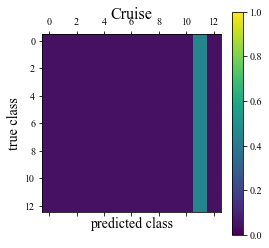

In [14]:
cm = np.ones((M_classes, M_classes))
cm = cm * 0.1
cm[:, chosen] = 1.
plasticc = wrap_up_classifier(cm, 'Cruise', plasticc, delta=0.01)

### Subsumed classifiers

Subsumed to: the chosen class is consistently misclassified as a different class

Subsumed from: another class is consistently misclassified as the chosen class

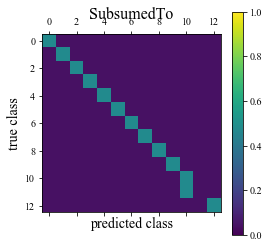

In [15]:
cm = plasticc['cm']['Almost'].copy()
cm[chosen] = cm[chosen-1]
plasticc = wrap_up_classifier(cm, 'SubsumedTo', plasticc, delta=0.01)

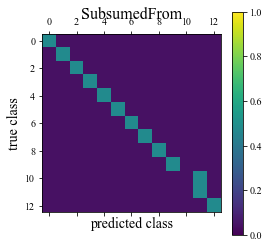

In [16]:
cm = plasticc['cm']['Almost'].copy()
cm[chosen-1] = cm[chosen]
plasticc = wrap_up_classifier(cm, 'SubsumedFrom', plasticc, delta=0.01)

## Real classification results

* SNPhotCC \[from Michelle?\]
* \[Ashish's data?\]
* Mystery \[Renee's data?\]

*show confusion matrices*

In [17]:
# These are all functions for preprocessing Renee's data files.

def make_class_pairs(data_info_dict):
    for name in data_info_dict['names']:
        data_info_dict['class_pairs'][name] = [data_info_dict['classifications'][name], data_info_dict['truth_tables'][name]]
    return(data_info_dict['class_pairs'])
        
def make_file_locs(data_info_dict):
    data_info_dict['classifications'] = {}
    data_info_dict['truth_tables'] = {}
    data_info_dict['class_pairs'] = {}
    data_info_dict['probs'] = {}
    data_info_dict['truth'] = {}
    names = data_info_dict['names']
    data_info_dict['dirname'] = topdir + data_info_dict['label'] + '/'
    for name in names:
        data_info_dict['classifications'][name] = '%s/predicted_prob_%s.csv'%(name, name)
        data_info_dict['truth_tables'][name] = '%s/truth_table_%s.csv'%(name, name)
    return data_info_dict

def process_strings(dataset, cc):
    loc = dataset['dirname']
    text = dataset['label'] + ' ' + dataset['names'][cc]
    return loc, text

def plot_cm(probs, truth, text, loc=''):
    cm = proclam.metrics.util.prob_to_cm(probs, truth)
    plt.matshow(cm.T, vmin=0., vmax=1.)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.title(text)
#     plt.show()
    plt.savefig(loc+'plot.png', dpi=250)
    plt.close()
    
def just_plot_cm(dataset, cc, pmat, tvec):
    fileloc, text = process_strings(dataset, cc)
    plot_cm(pmat, tvec, text, loc=fileloc + dataset['names'][cc] + '/')
    return

def just_read_class_pairs(pair, dataset, cc):
    loc, text = process_strings(dataset, cc)
    clfile = pair[0]
    truthfile = pair[1]
    prob_mat = pd.read_csv(loc + clfile, delim_whitespace=True).values
    nobj = np.shape(prob_mat)[0]
    nclass = np.shape(prob_mat)[1]
    truth_values = pd.read_csv(loc + truthfile, delim_whitespace=True).values
    nobj_truth = np.shape(truth_values)[0]
    nclass_truth = np.shape(truth_values)[1]
    tvec = np.where(truth_values==1)[1]
    pmat = prob_mat
    return pmat, tvec

def read_class_pairs(pair, dataset, cc):
    fileloc, text = process_strings(dataset, cc)
    pmat, tvec = just_read_class_pairs(pair, dataset, cc)
    filename = fileloc + dataset['names'][cc] + '/'
    plot_cm(pmat, tvec, text, loc=filename)
    return pmat, tvec

In [18]:
topdir = '../examples/'
mystery = {}
mystery['label'] = 'Unknown'
mystery['names'] = ['RandomForest', 'KNeighbors', 'MLPNeuralNet']
# mystery['classifications'] = {}
# mystery['truth_tables'] = {}
# mystery['class_pairs'] = {}
# mystery['probs'] = {}
# mystery['truth'] = {}
mystery = make_file_locs(mystery)
mystery['class_pairs'] = make_class_pairs(mystery)

In [19]:
snphotcc = {}
snphotcc['label'] = 'SNPhotCC'
prefixes = ['Templates', 'Wavelets']
suffixes = ['BoostForest', 'KNN', 'NB', 'NeuralNetwork', 'SVM']
snphotcc['names'] = []
for prefix in prefixes:
    for suffix in suffixes:
        snphotcc['names'].append(prefix+suffix)

In [20]:
topdir = '../examples/'
for dataset in [mystery, snphotcc]:
    dataset = make_file_locs(dataset)
    dataset['class_pairs'] = make_class_pairs(dataset)
    for nm, name in enumerate(dataset['names']):
        probm, truthv = read_class_pairs(dataset['class_pairs'][name], dataset, nm)
        print(dataset['class_pairs'][name])
        dataset['probs'][name] = probm
        dataset['truth'][name] = truthv

['RandomForest/predicted_prob_RandomForest.csv', 'RandomForest/truth_table_RandomForest.csv']
['KNeighbors/predicted_prob_KNeighbors.csv', 'KNeighbors/truth_table_KNeighbors.csv']
['MLPNeuralNet/predicted_prob_MLPNeuralNet.csv', 'MLPNeuralNet/truth_table_MLPNeuralNet.csv']
['TemplatesBoostForest/predicted_prob_TemplatesBoostForest.csv', 'TemplatesBoostForest/truth_table_TemplatesBoostForest.csv']
['TemplatesKNN/predicted_prob_TemplatesKNN.csv', 'TemplatesKNN/truth_table_TemplatesKNN.csv']
['TemplatesNB/predicted_prob_TemplatesNB.csv', 'TemplatesNB/truth_table_TemplatesNB.csv']
['TemplatesNeuralNetwork/predicted_prob_TemplatesNeuralNetwork.csv', 'TemplatesNeuralNetwork/truth_table_TemplatesNeuralNetwork.csv']
['TemplatesSVM/predicted_prob_TemplatesSVM.csv', 'TemplatesSVM/truth_table_TemplatesSVM.csv']
['WaveletsBoostForest/predicted_prob_WaveletsBoostForest.csv', 'WaveletsBoostForest/truth_table_WaveletsBoostForest.csv']
['WaveletsKNN/predicted_prob_WaveletsKNN.csv', 'WaveletsKNN/truth_

In [21]:
def plot_cm(probs, truth, text, loc=''):
    cm = proclam.metrics.util.prob_to_cm(probs, truth)
    plt.matshow(cm.T, vmin=0., vmax=1.)
# plt.xticks(range(max(truth)+1), names)
# plt.yticks(range(max(truth)+1), names)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.title(text)
    plt.show()
#     plt.savefig(loc+name+'_cm.png')
    plt.close()

Methods (Metrics)
======

We considered two metrics of classification probabilities, each of which is interpretable and avoids reducing probabilities to point estimates

The Brier score is defined as
\begin{eqnarray*}
B &=& \sum_{m=1}^{M}\frac{w_{m}}{N_{m}}\sum_{n=1}^{N_{m}}\left((1-p_{n}(m | m))^{2}+\sum_{m'\neq m}^{M}(p_{n}(m' | m))^{2}\right)
\end{eqnarray*}

The log-loss is defined as
\begin{eqnarray*}
L &=& -\sum_{m=1}^{M}\frac{w_{m}}{N_{m}}\sum_{n=1}^{N_{m}}\ln[p_{n}(m | m)]
\end{eqnarray*}

We calculate the metric within each class $m$ by taking an average of its value $-\ln[p_{n}(m | m)]$ for each true member $n$ of the class.  Then we weight the metrics for each class by an arbitrary weight $w_{m}$ and take a weighted average of the per-class metrics to produce a global scalar metric.

In [22]:
metricslist = ['Brier', 'LogLoss']
colors = ['g', 'b', 'm', 'y', 'c']
markerlist = ['o', 's', '*', '+', 'x']

### Weights

We may take weighted averages of the per-class metrics, and these weights may be considered in terms of the systematics we discussed, by upweighting or downweighting the "chosen" class most affected by the systematics.

In [23]:
chosen = {}
chosen['weights'] = {}
chosen['names'] = {'common': 0, 'rare': 4, 'subsumer': 5, 'subsumee': 6, 'invisible': 8}
ideas = chosen['names'].keys()
M_classes = 13

for idea in chosen['names'].keys():
    chosen['weights'][idea] = {}
    cc = chosen['names'][idea]
    flat_weight = np.ones(M_classes)
    hi_weight = np.ones(M_classes) / np.float(M_classes)
    hi_weight[cc] = 1.
    lo_weight = np.ones(M_classes) 
    lo_weight[cc] = 1. / np.float(M_classes)
    chosen['weights'][idea]['flat'] = flat_weight
    chosen['weights'][idea]['up'] = hi_weight
    chosen['weights'][idea]['down'] = lo_weight
    chosen['weights'][idea]['per_class'] = 'per_class'
    chosen['weights'][idea]['per_item'] = 'per_item'
    
schemes = ['flat', 'up', 'down', 'per_class', 'per_item']

Results
=======

*one plot per set of "true" classes: classifiers on x axis, metrics on y axes*

## Mock classifier systematics

In [24]:
generator = proclam.simulators.LogUnbalanced()
N_objects = 10000
truth = generator.simulate(M_classes, N_objects)

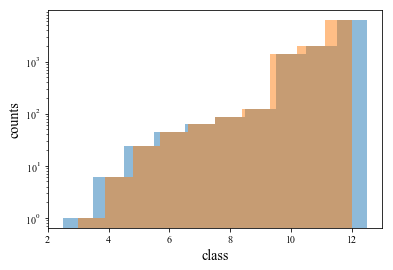

In [25]:
d = np.diff(np.unique(truth)).min()
left_of_first_bin = truth.min() - float(d)/2
right_of_last_bin = truth.max() + float(d)/2
plt.hist(truth, np.arange(left_of_first_bin, right_of_last_bin + d, d), log=True, alpha=0.5)
# plt.xticks(range(max(truth)+1), names)
plt.hist(truth, log=True, alpha=0.5)
plt.ylabel('counts')
plt.xlabel('class')
plt.show()
plt.close()

In [26]:
# data = np.empty((len(metricslist), len(plasticc['names'])))
plasticc['probs'] = {}
for cc, name in enumerate(plasticc['names']):
    code = proclam.classifiers.FromCM()
    probs = code.classify(plasticc['cm'][name], truth, delta=plasticc['delta'][name], other=False)
    plasticc['probs'][name] = probs
#     for count, metric in enumerate(metricslist):
#         D = getattr(proclam.metrics, metric)()
#         hm = D.evaluate(probs, truth, averaging='per_class')
#         data[count][cc] = hm
#     plasticc['probs'] = data

In [27]:
# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)
        
# def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
#     plot_n = n+1
#     in_x = np.arange(len(codes))
#     ax_n = ax
#     n_factor = 0.1 * (plot_n - 2)
#     if plot_n>1:
#         ax_n = ax.twinx()
#         rot_ang = 270
#         label_space = 15.
#     else:
#         rot_ang = 90
#         label_space = 0.
#     if plot_n>2:
#         ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
#         make_patch_spines_invisible(ax_n)
#         ax_n.spines["right"].set_visible(True)
#     handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
#     ax_n.set_ylabel(metric_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
# #     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
#     return(ax, ax_n, handle)

# def metric_plot(dataset, res, metric_names, shapes, colors, modtext=''):
#     codes = dataset['names']
#     data = res
#     text = dataset['label']
# #     fileloc = dataset['dirname']+dataset['label']+'_results.png'
#     xs = np.arange(len(codes))
#     fig, ax = plt.subplots()
#     fig.subplots_adjust(right=1.)
#     handles = []
#     for n in range(len(metric_names)):
# #         print(np.shape(data[n]))
#         (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
#         handles.append(handle)
#     plt.xticks(xs, codes)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)
#     plt.xlabel('Classifiers', fontsize=14)
#     plt.legend(handles, metric_names, loc='lower left')
#     fig.suptitle(text+modtext)
#     plt.savefig(text+modtext+'.png')
#     return

# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
    n_factor = 0.1 * (plot_n - 2)
#     if plot_n>1:
#         ax_n = ax.twinx()
#         rot_ang = 270
#         label_space = 15.
#     else:
#         rot_ang = 90
#         label_space = 0.
#     if plot_n>2:
#         ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
#         make_patch_spines_invisible(ax_n)
#         ax_n.spines["right"].set_visible(True)
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
#     ax_n.set_ylabel(metric_names[n], fontsize=14)#s, labelpad=label_space, rotation=rot_ang)
#     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
    return(ax, ax_n, handle)

def metric_plot(dataset, res, metric_names, shapes, colors, modtext='', fn='plot.png'):
    codes = dataset['names']
    data = res
    text = dataset['label']
#     fileloc = dataset['dirname']+dataset['label']+'_results.png'
    xs = np.arange(len(codes))
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
    for n in range(len(metric_names)):
#         print(np.shape(data[n]))
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
    plt.xticks(xs, codes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
    plt.ylabel('LogLoss')
    plt.legend(handles, metric_names, loc='upper left')
    fig.suptitle(text+modtext)
    plt.show()
    plt.savefig(fn, dpi=250)
    plt.close()
    return

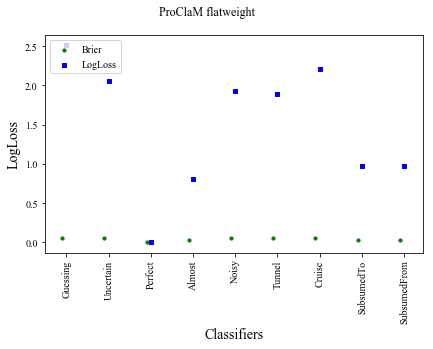

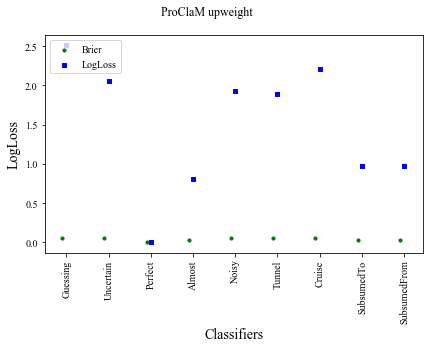

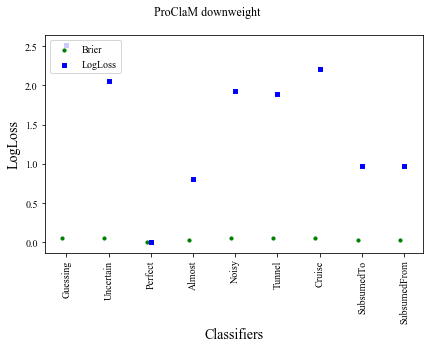

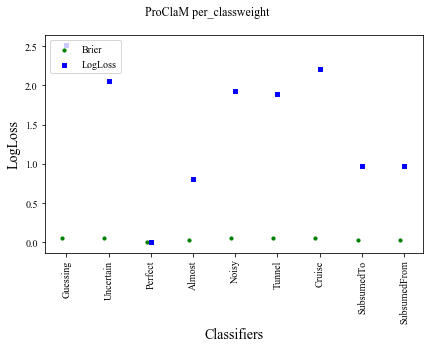

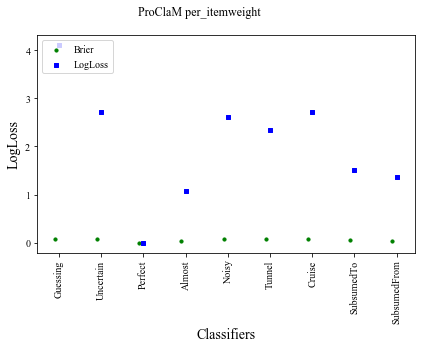

In [28]:
for wt in schemes:
    data = np.empty((len(metricslist), len(plasticc['names'])))
    for cc, name in enumerate(plasticc['names']):
        probs = plasticc['probs'][name]
        for count, metric in enumerate(metricslist):
            D = getattr(proclam.metrics, metric)()
            hm = D.evaluate(probs, truth, averaging=wt)
            data[count][cc] = hm
#     plasticc['results'] = data
    metric_plot(plasticc, data, metricslist, markerlist, colors, modtext=' '+wt+'weight')

invisible flat: [ 4.7054062 21.2642751  6.7887405]
invisible up: [ 9.38351121 26.96085674  7.76940279]
invisible down: [ 3.96048502 20.35717611  6.63258409]
invisible per_class: [ 4.7054062 21.2642751  6.7887405]
invisible per_item: [0.55822216 9.42475054 1.64560879]


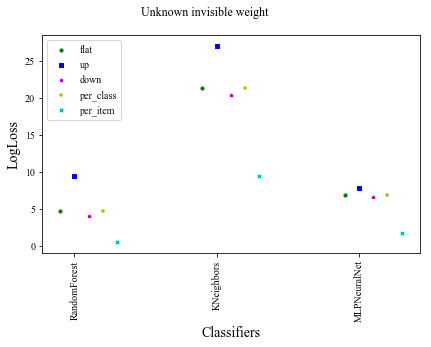

subsumer flat: [ 4.7054062 21.2642751  6.7887405]
subsumer up: [ 3.38160786 23.58321407  5.3116203 ]
subsumer down: [ 4.91620212 20.8950173   7.02395073]
subsumer per_class: [ 4.7054062 21.2642751  6.7887405]
subsumer per_item: [0.55822216 9.42475054 1.64560879]


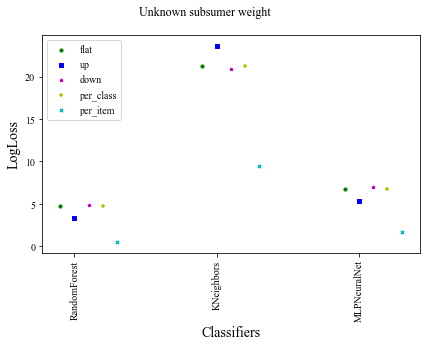

rare flat: [ 4.7054062 21.2642751  6.7887405]
rare up: [14.60670399 28.35837668 13.65394687]
rare down: [ 3.12876643 20.13464109  5.69555477]
rare per_class: [ 4.7054062 21.2642751  6.7887405]
rare per_item: [0.55822216 9.42475054 1.64560879]


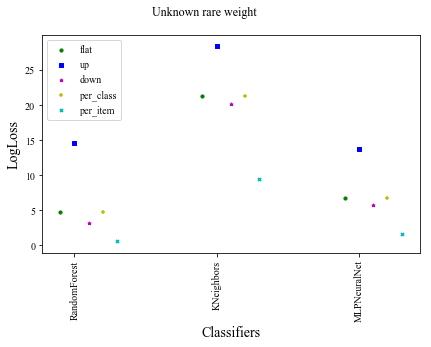

common flat: [ 4.7054062 21.2642751  6.7887405]
common up: [ 2.63138856 14.7949635   4.09555262]
common down: [ 5.03566379 22.29442026  7.21759208]
common per_class: [ 4.7054062 21.2642751  6.7887405]
common per_item: [0.55822216 9.42475054 1.64560879]


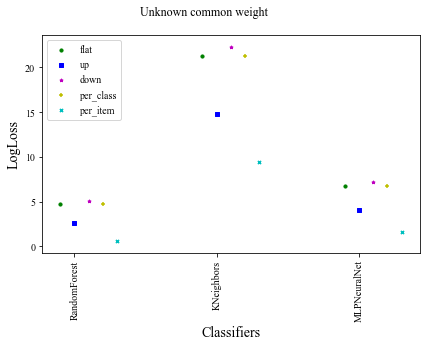

subsumee flat: [ 4.7054062 21.2642751  6.7887405]
subsumee up: [ 3.43987361 22.59139214  8.03158277]
subsumee down: [ 4.90692413 21.05295073  6.59083568]
subsumee per_class: [ 4.7054062 21.2642751  6.7887405]
subsumee per_item: [0.55822216 9.42475054 1.64560879]


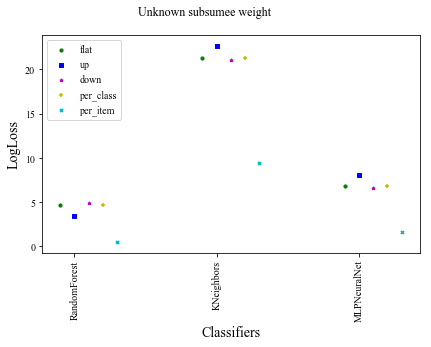

In [29]:
# loop over datasets, loop over 

data = np.empty((len(chosen['names'].keys()), len(schemes), len(mystery['names'])))
# data = np.empty((len(schemes), len(chosen['names'].keys()), len(mystery['names'])))

for cc, idea in enumerate(chosen['names'].keys()):
    for sc, scheme in enumerate(schemes):
# for sc, scheme in enumerate(schemes): 
#     for cc, idea in enumerate(chosen['names'].keys()):
        for nm, name in enumerate(mystery['names']):
            probm = mystery['probs'][name]
            truthv = mystery['truth'][name]
            D = getattr(proclam.metrics, 'LogLoss')()
            weighting = idea+' '+scheme
            hm = D.evaluate(prediction=probm, truth=truthv, averaging=chosen['weights'][idea][scheme])
            data[cc][sc][nm] = hm
#             data[sc][cc][nm] = hm
        print(weighting+': '+str(data[cc][sc]))
#         print(weighting+': '+str(data[sc][cc]))
    metric_plot(mystery, data[cc], schemes, markerlist, colors, modtext=' '+idea+' weight', fn=idea+'.png')
#     metric_plot(mystery, data[sc], list(ideas), markerlist, colors, modtext=' '+scheme+' weight', fn=scheme+'.png')

invisible flat: [ 4.7054062 21.2642751  6.7887405]
subsumer flat: [ 4.7054062 21.2642751  6.7887405]
rare flat: [ 4.7054062 21.2642751  6.7887405]
common flat: [ 4.7054062 21.2642751  6.7887405]
subsumee flat: [ 4.7054062 21.2642751  6.7887405]


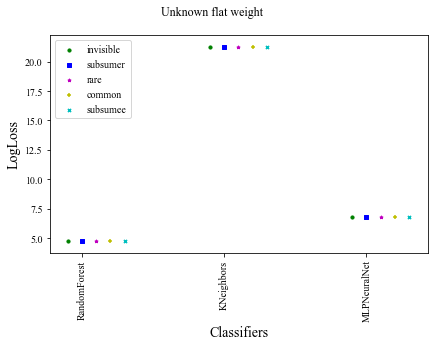

invisible up: [ 9.38351121 26.96085674  7.76940279]
subsumer up: [ 3.38160786 23.58321407  5.3116203 ]
rare up: [14.60670399 28.35837668 13.65394687]
common up: [ 2.63138856 14.7949635   4.09555262]
subsumee up: [ 3.43987361 22.59139214  8.03158277]


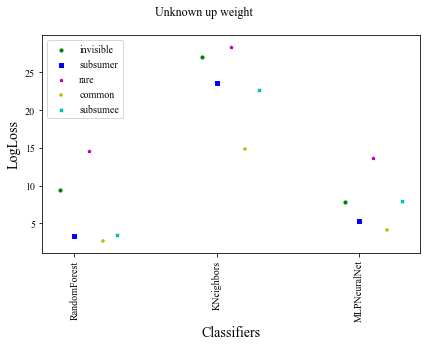

invisible down: [ 3.96048502 20.35717611  6.63258409]
subsumer down: [ 4.91620212 20.8950173   7.02395073]
rare down: [ 3.12876643 20.13464109  5.69555477]
common down: [ 5.03566379 22.29442026  7.21759208]
subsumee down: [ 4.90692413 21.05295073  6.59083568]


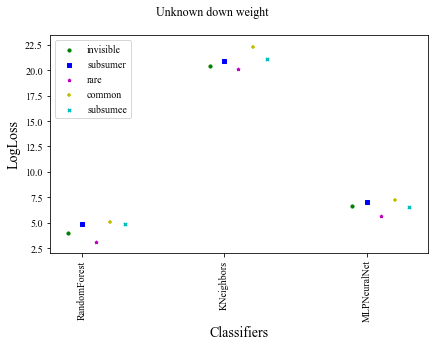

invisible per_class: [ 4.7054062 21.2642751  6.7887405]
subsumer per_class: [ 4.7054062 21.2642751  6.7887405]
rare per_class: [ 4.7054062 21.2642751  6.7887405]
common per_class: [ 4.7054062 21.2642751  6.7887405]
subsumee per_class: [ 4.7054062 21.2642751  6.7887405]


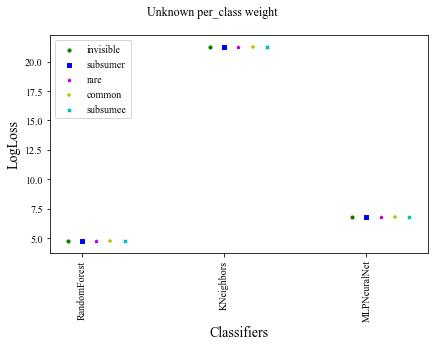

invisible per_item: [0.55822216 9.42475054 1.64560879]
subsumer per_item: [0.55822216 9.42475054 1.64560879]
rare per_item: [0.55822216 9.42475054 1.64560879]
common per_item: [0.55822216 9.42475054 1.64560879]
subsumee per_item: [0.55822216 9.42475054 1.64560879]


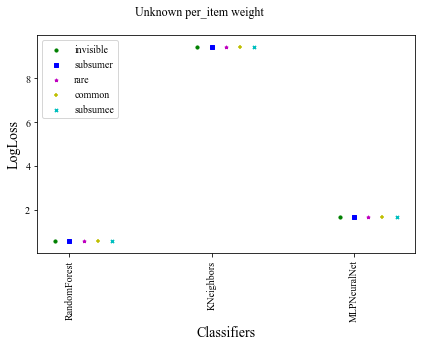

In [30]:
# data = np.empty((len(chosen['names'].keys()), len(schemes), len(mystery['names'])))
data = np.empty((len(schemes), len(chosen['names'].keys()), len(mystery['names'])))

# for cc, idea in enumerate(chosen['names'].keys()):
#     for sc, scheme in enumerate(schemes):
for sc, scheme in enumerate(schemes): 
    for cc, idea in enumerate(chosen['names'].keys()):
        for nm, name in enumerate(mystery['names']):
            probm = mystery['probs'][name]
            truthv = mystery['truth'][name]
            D = getattr(proclam.metrics, 'LogLoss')()
            weighting = idea+' '+scheme
            hm = D.evaluate(prediction=probm, truth=truthv, averaging=chosen['weights'][idea][scheme])
#             data[cc][sc][nm] = hm
            data[sc][cc][nm] = hm
#         print(weighting+': '+str(data[cc][sc]))
        print(weighting+': '+str(data[sc][cc]))
#     metric_plot(mystery, data[cc], schemes, markerlist, colors, modtext=' '+idea+' weight', fn=idea+'.png')
    metric_plot(mystery, data[sc], list(ideas), markerlist, colors, modtext=' '+scheme+' weight', fn=scheme+'.png')

Would like to do this many times to generate error bars

Try with different weights relative to randomly chosen class

## Real classification results

In [31]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
    n_factor = 0.1 * (plot_n - 2)
    if plot_n>1:
        ax_n = ax.twinx()
        rot_ang = 270
        label_space = 15.
    else:
        rot_ang = 90
        label_space = 0.
    if plot_n>2:
        ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
        make_patch_spines_invisible(ax_n)
        ax_n.spines["right"].set_visible(True)
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
    ax_n.set_ylabel(metric_names[n], fontsize=14, rotation=rot_ang)#s, labelpad=label_space, rotation=rot_ang)
#     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
    return(ax, ax_n, handle)

def metric_plot(dataset, res, metric_names, shapes, colors, modtext='', fn='plot.png'):
    codes = dataset['names']
    data = res
    text = dataset['label']
#     fileloc = dataset['dirname']+dataset['label']+'_results.png'
    xs = np.arange(len(codes))
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
    for n in range(len(metric_names)):
#         print(np.shape(data[n]))
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
    plt.xticks(xs, codes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
#     plt.ylabel('LogLoss')
    plt.legend(handles, metric_names, loc='upper left')
    fig.suptitle(text+modtext)
    plt.show()
    plt.savefig(fn, dpi=250)
    plt.close()
    return

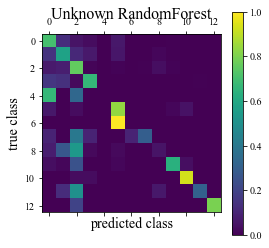

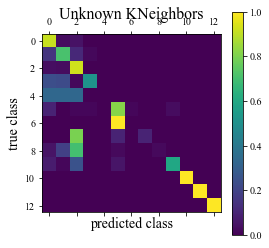

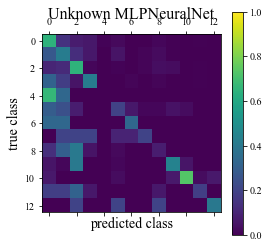

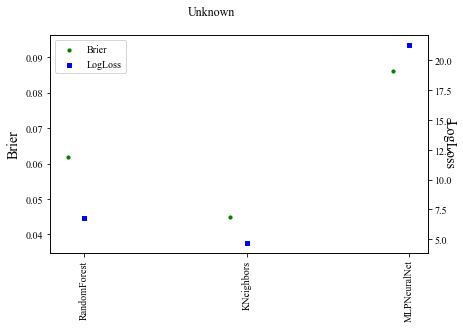

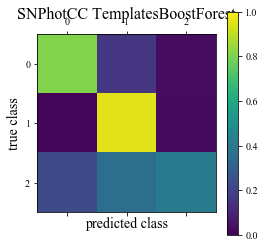

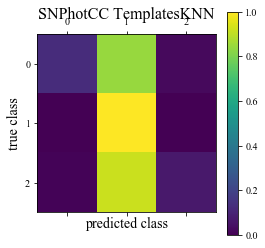

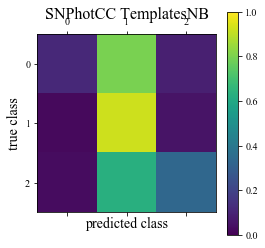

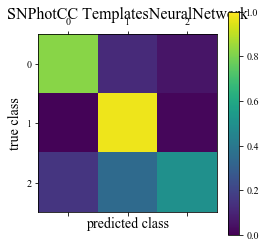

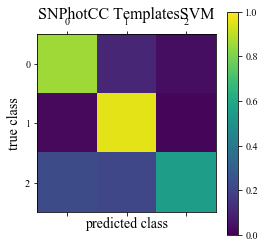

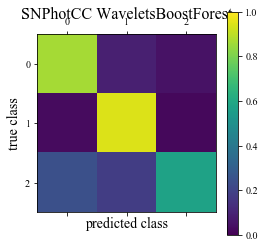

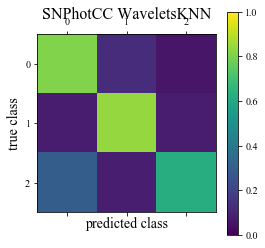

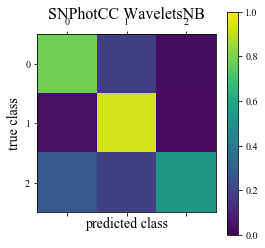

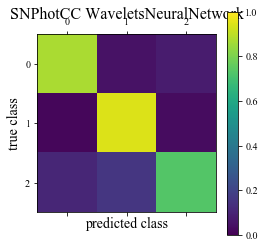

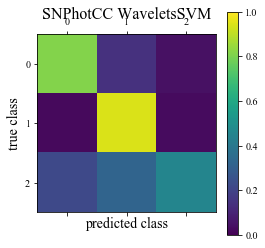

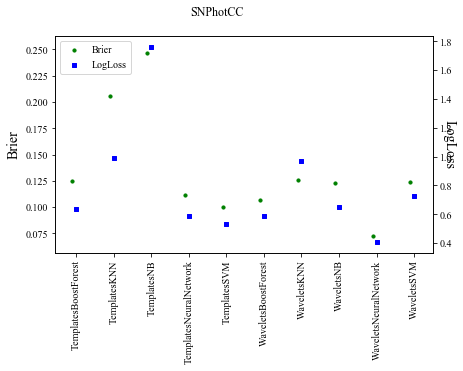

In [32]:
for dataset in [mystery, snphotcc]:
    data = np.empty((len(metricslist), len(dataset['names'])))
    for cc, name in enumerate(dataset['class_pairs'].keys()):
        probm, truthv = read_class_pairs(dataset['class_pairs'][name], dataset, cc)
        for count, metric in enumerate(metricslist):
            D = getattr(proclam.metrics, metric)()
            hm = D.evaluate(probm, truthv)
            data[count][cc] = hm
#     dataset['results'] = data
    metric_plot(dataset, data, metricslist, markerlist, colors)

In [33]:
# metric_plot(snphotcc, metricslist, markerlist, colors)

In [34]:
# metric_plot(mystery, metricslist, markerlist, colors)

Conclusions
===========

We conclude that the Brier and log-loss metrics convey different information but are more or less consistent with our intuition for what makes a good classifier.  The Brier metric includes a penalty term not present in the log-loss but somehow is always consistent with the log-loss, meaning the penalty term doesn't really make a difference.  The log-loss has a larger dynamic range, which seems good but probably isn't that big a deal either.

Acknowledgments
===============

The DESC acknowledges ongoing support from the Institut National de Physique Nucleaire et de Physique des Particules in France; the Science & Technology Facilities Council in the United Kingdom; and the Department of Energy, the National Science Foundation, and the LSST Corporation in the United States.

DESC uses resources of the IN2P3 Computing Center (CC-IN2P3--Lyon/Villeurbanne - France) funded by the Centre National de la Recherche Scientifique; the National Energy Research Scientific Computing Center, a DOE Office of Science User Facility supported by the Office of Science of the U.S. Department of Energy under Contract No. DE-AC02-05CH11231; STFC DiRAC HPC Facilities, funded by UK BIS National E-infrastructure capital grants; and the UK particle physics grid, supported by the GridPP Collaboration.

This work was performed in part under DOE Contract DE-AC02-76SF00515.

Contributions
=======

Alex Malz: conceptualization, data curation, formal analysis, investigation, methodology, project administration, software, supervision, validation, visualization, writing - original draft

Renee Hlozek: data curation, formal analysis, funding acquisition, investigation, project administration, software, supervision, validation, visualization, writing - original draft

Tarek Alam: investigation, software, validation

Anita Bahmanyar: formal analysis, investigation, methodology, software, writing - original draft

Rahul Biswas: conceptualization, methodology, software

Emille Ishida: conceptualization, project administration, supervision

David Jones: software

Ashish Mahabal: data curation, software

Rafael Martinez-Galarza: data curation, software, visualization

Gautham Narayan: data curation, formal analysis

In [35]:
# cells with a tag of "hideme" will not appear in html resulting from:
# jupyter nbconvert desc_note/main.ipynb --TagRemovePreprocessor.remove_cell_tags='["hideme"]'
# jupyter nbconvert desc_note/main.ipynb --TagRemovePreprocessor.remove_input_tags='["hidein"]'
